In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

# Loading the training set

In [ ]:
%%time
dir = Path('/kaggle/input/brain-tumor-mri-dataset/Training')

filepaths = list(dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe_train = pd.concat([filepaths , labels] , axis=1)
dataframe_train


CPU times: user 76.9 ms, sys: 41.6 ms, total: 118 ms
Wall time: 1.04 s


,Filepath,Label
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [ ]:
dataframe_train['Label'].value_counts()

notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: Label, dtype: int64

# Loading the test set

In [ ]:
%%time
dir = Path('/kaggle/input/brain-tumor-mri-dataset/Testing')

filepaths = list(dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe_test = pd.concat([filepaths , labels] , axis=1)
dataframe_test

CPU times: user 18.5 ms, sys: 1.95 ms, total: 20.5 ms
Wall time: 23.1 ms


,Filepath,Label
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


In [ ]:
dataframe_test['Label'].value_counts()

notumor       405
meningioma    306
pituitary     300
glioma        300
Name: Label, dtype: int64

# Preprocessing with ImageDataGenerators

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True

)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True

)

In [ ]:
size=64
color_mode='grayscale'
batch_size=32
train_images = train_generator.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
)

test_images = test_generator.flow_from_dataframe(
    dataframe=dataframe_test,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [ ]:
test_images.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

# Modelling

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *


model = Sequential()

model.add(Conv2D(64,(7,7), input_shape=(64, 64, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

#Convolutional layer 2
model.add(Conv2D(128,(7,7), input_shape=(64, 64, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 3
model.add(Conv2D(256,(7,7), input_shape=(64, 64, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 4
model.add(Conv2D(512,(7,7), input_shape=(64, 64, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Flatten())

# Full connect layers

model.add(Dense(units= 512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=4, activation='softmax'))



model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_128 (Conv2D)          (None, 64, 64, 64)        3200      
_________________________________________________________________
batch_normalization_127 (Bat (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_127 (MaxPoolin (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 32, 32, 128)       401536    
_________________________________________________________________
batch_normalization_128 (Bat (None, 32, 32, 128)       512       
_________________________________________________________________
max_pooling2d_128 (MaxPoolin (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 16, 16, 256)     

# Architecture visualization

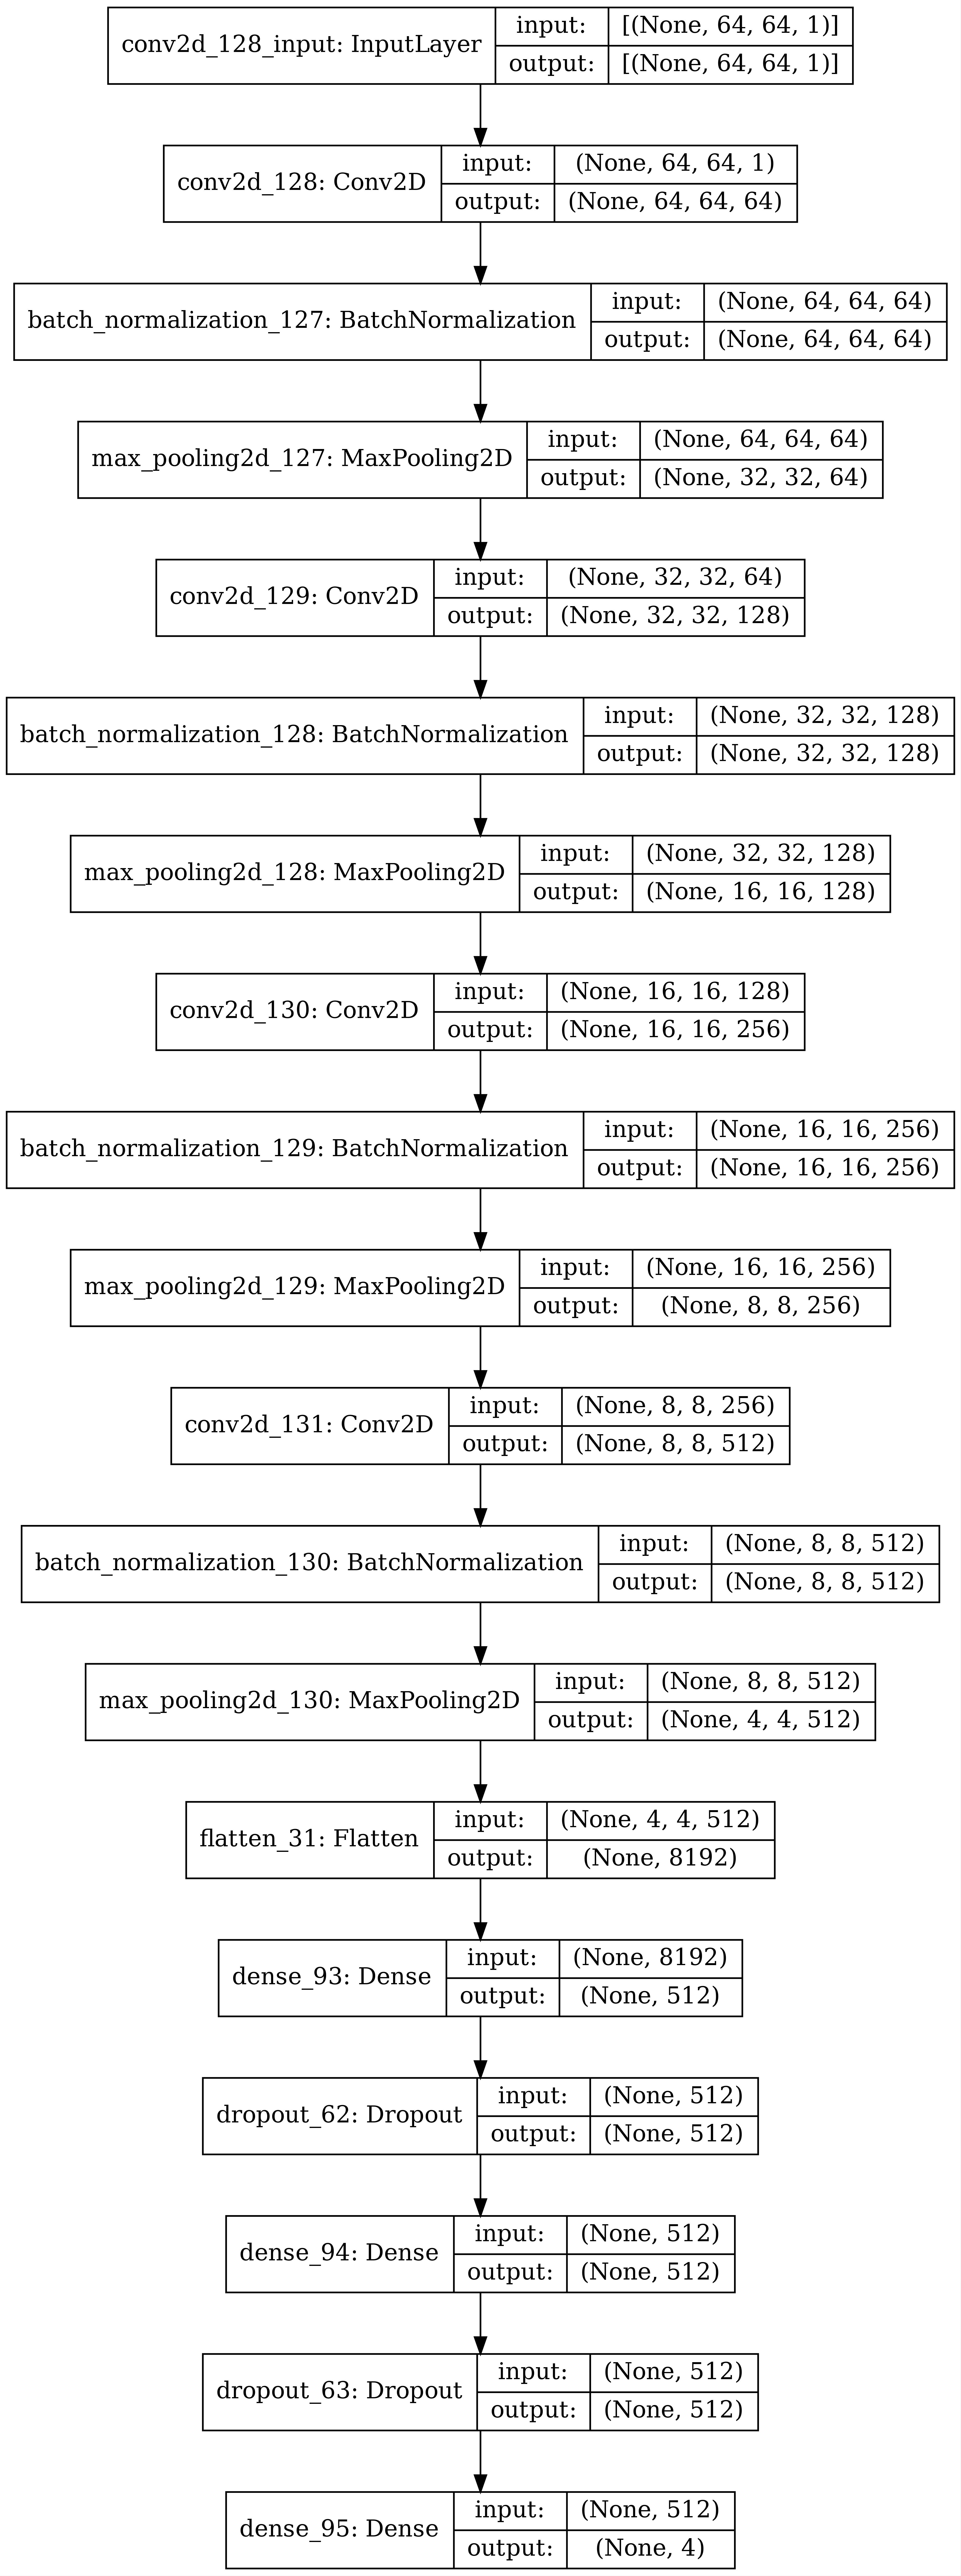

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(
    model,
    to_file="model.jpg",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=500
)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0001, clipvalue=0.5)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy',
             'Precision',
             'Recall',
             tf.keras.metrics.AUC(
                                    num_thresholds=200,
                                    curve="ROC",
                                    summation_method="interpolation",
                                    multi_label=False,
                                    from_logits=False)
        ]
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    save_weights_only=False,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)


# Fitting

In [ ]:
%%time
result=model.fit(
    train_images,
    steps_per_epoch=5712//32,
    validation_data=test_images,
    validation_steps= 1311//32,
    epochs=30,
    callbacks=[es,rlr,checkpoint]
)

Epoch 1/30
178/178 [==============================] - 24s 129ms/step - loss: 1.1346 - categorical_accuracy: 0.6363 - precision: 0.6787 - recall: 0.5713 - auc_8: 0.8572 - val_loss: 2.5499 - val_categorical_accuracy: 0.2844 - val_precision: 0.2913 - val_recall: 0.2797 - val_auc_8: 0.5841

Epoch 00001: val_categorical_accuracy improved from -inf to 0.28438, saving model to best_model.h5
Epoch 2/30
178/178 [==============================] - 23s 131ms/step - loss: 0.6816 - categorical_accuracy: 0.7394 - precision: 0.7786 - recall: 0.6879 - auc_8: 0.9261 - val_loss: 1.2315 - val_categorical_accuracy: 0.4563 - val_precision: 0.5303 - val_recall: 0.3555 - val_auc_8: 0.7419

Epoch 00002: val_categorical_accuracy improved from 0.28438 to 0.45625, saving model to best_model.h5
Epoch 3/30
178/178 [==============================] - 23s 129ms/step - loss: 0.5291 - categorical_accuracy: 0.8023 - precision: 0.8309 - recall: 0.7646 - auc_8: 0.9534 - val_loss: 0.6971 - val_categorical_accuracy: 0.7312 -

# Testing results


In [ ]:
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import cohen_kappa_score, f1_score
from keras.models import load_model

best_model=load_model('/kaggle/working/best_model.h5', custom_objects={'AFR': AFR})
results = best_model.evaluate(test_images, verbose=0)
y_pred = best_model.predict(test_images)
y_pred=np.argmax(y_pred, axis=1)

print("     Test Loss: {:.4f}".format(results[0]))
print(" Test Accuracy: {:.2f}%".format(results[1] * 100))
print("Test Precision: {:.2f}%".format(results[2] * 100))
print("   Test Recall: {:.2f}%".format(results[3] * 100))
print(" Test f1-score: {:.2f}%".format(f1_score(test_images.labels, y_pred, average='micro') * 100))
print("      Test AUC: {:.4f}".format(results[4] ))
print("         Gmean: {:.2f}%".format(geometric_mean_score(test_images.labels, y_pred)*100) )
print("         kappa: {:.2f}%".format(cohen_kappa_score(test_images.labels, y_pred)*100) )

     Test Loss: 0.0318
 Test Accuracy: 99.1609%
Test Precision: 99.1609%
   Test Recall: 99.1609%
      Test AUC: 0.9998


# Classification report & Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


cm = confusion_matrix(test_images.labels, y_pred)
print(cm)
print('classification report')

report = classification_report(test_images.labels, y_pred, target_names=['glioma','meningioma','notumor','pituitary'],digits=4)
print(report )

def report_to_df(report):
    report = [x.split(' ') for x in report.split('\n')]
    header = ['Class Name']+[x for x in report[0] if x!='']
    values = []
    for row in report[1:-5]:
        row = [value for value in row if value!='']
        if row!=[]:
            values.append(row)
    df = pd.DataFrame(data = values, columns = header)
    return df
report = report_to_df(report)

report.to_csv('classification report.csv', index=True)


[[295   5   0   0]
 [  1 300   3   2]
 [  0   0 405   0]
 [  0   1   0 299]]
classification report
              precision    recall  f1-score   support

      glioma     0.9966    0.9833    0.9899       300
  meningioma     0.9804    0.9804    0.9804       306
     notumor     0.9926    1.0000    0.9963       405
   pituitary     0.9934    0.9967    0.9950       300

    accuracy                         0.9908      1311
   macro avg     0.9908    0.9901    0.9904      1311
weighted avg     0.9909    0.9908    0.9908      1311



# Visualization of training and validation curves

In [ ]:
plt.figure(figsize=(20,10))
r=2
c=3

plt.subplot(r,c,1)
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy');

plt.subplot(r,c,2)
plt.plot(result.history['recall'])
plt.plot(result.history['val_recall'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation Recall')
plt.xlabel('epoch')
plt.ylabel('Recall');

plt.subplot(r,c,3)
plt.plot(result.history['precision'])
plt.plot(result.history['val_precision'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation Precision')
plt.xlabel('epoch')
plt.ylabel('Precision');

plt.subplot(r,c,4)
plt.plot(result.history['auc'])
plt.plot(result.history['val_auc'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation AUC')
plt.xlabel('epoch')
plt.ylabel(' AUC')

plt.subplot(r,c,5)
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')
plt.ylabel('Dice loss')
plt.subplots_adjust(hspace=0.3)

plt.subplot(r,c,6)
x = ['Acc', 'Precision', 'Recall','F1-score' ,'AUC']
y = [results[1],results[2] ,results[3],f1_score(test_images.labels, y_pred, average='micro'),results[4]]
plt.bar(x, y, color='red')
plt.xlabel('Measure')
plt.ylabel('Value')
plt.title('Test Measures')

plt.rcParams['font.size'] = '10'

plt.savefig( 'curves.jpg', dpi=1000, bbox_inches = 'tight')

# Visualization of confusion matrix

Confusion matrix, without normalization


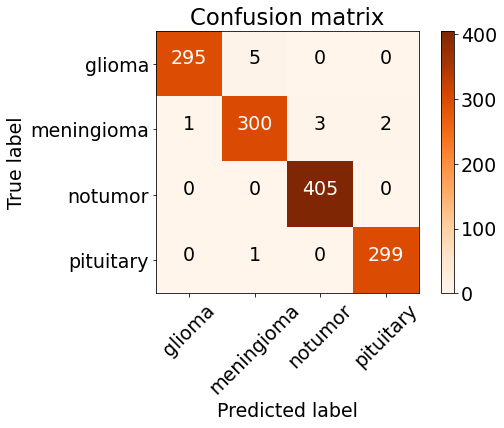

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.colorbar()

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.rcParams['font.size'] = '18'


plot_confusion_matrix(cm, classes=['glioma','meningioma','notumor','pituitary'],normalize=False,title='Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion matrix' + '.jpg', dpi=500, bbox_inches = 'tight')

Normalized confusion matrix


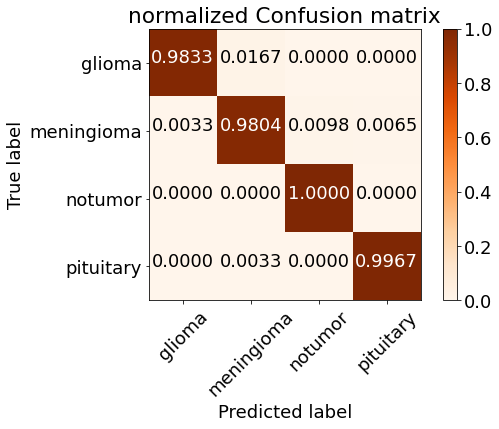

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.colorbar()

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.rcParams['font.size'] = '18'


plot_confusion_matrix(cm, classes=['glioma','meningioma','notumor','pituitary'],normalize=True,title='normalized Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('normalized confusion matrix' + '.jpg', dpi=500, bbox_inches = 'tight')

# Making predictions on a new sample

In [1]:
import cv2 
from keras.models import load_model

img = cv2.imread('test-image.jpg')
model = load_model("best_model.h5")
img = cv2.resize(img, (64, 64))
if img.shape[2] == 3:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img = img / 255
pred1 = model.predict(img.reshape(1, 64, 64, 1), batch_size=1, verbose=0)
pred = pred1.argmax()
brain_labels = {0: "glioma", 1: "meningioma", 2: "no tumor", 3: "pituitary"}
x = brain_labels.get(pred, "Unknown")
y = x + ", " + (pred1[0][pred] * 100).astype("str")[:6] + "%"
print(y)

meningioma, 100.0%
